In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Read, transform dataset

In [2]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [10]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words)))) # All individual words in the dataset
stoi = {s:i+1 for i,s in enumerate(chars)} # String to integer mapping
stoi['.'] = 0 # In the vocabulary doen't exist the '.' character by default, we include it at the first position
itos = {i:s for s,i in stoi.items()} # Integer to string mapping
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
# Example representing a name as a list of numbers
characters_integer = []
for ch in 'emma':
    characters_integer.append(stoi[ch])

print(torch.tensor(characters_integer))

tensor([ 5, 13, 13,  1])


### Create training, validation and test datasets

In [12]:
# Build the dataset

block_size = 3 # Context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        # Creates a list with three elements, each of which is 0
        # This context list will be a sliding window always containing the previous three characters
        # in order to predict the next
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # Our input data now will be a context of size three different to the context of size one we builded
            # in the previous code lab
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            # Update the context window to include the lastest character while discarding the oldesde one
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% of the words
n2 = int(0.9*len(words)) # 90% of the words

Xtr, Ytr = build_dataset(words[:n1]) # 80% for training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% for validation/dev
Xte, Yte = build_dataset(words[n2:]) # 10% for test

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


### Define NN architecture

In [13]:
n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647)
# Each character is represented by a continuous vector of a fixed size (n_embd in this case)
# These embeddings are learned during training and can capture more information about characters
# in a more conpact form than one-hot vectors
C = torch.randn((27, n_embd), generator=g) # Character embedding matrix

# The expression `* (5/3)/(n_embd * block_size)**0.5` is a scaling factor applied to the initial
# weights of the neural network, specifically for the weights of the first layer(`W1`)

# By scaling the initial weights the network starts with weights that are neither too large
# (which can lead to exploding gradients) nor to small (leading to vanishing gradients)

# This scalling is specially important for networks using activation functions like tanh or sigmoid,
# where large weights can saturate the neurons at the start of training
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

# For batch normalization
batch_gain = torch.ones((1, n_hidden))
batch_bias = torch.zeros((1, n_hidden))
batch_n_mean_running = torch.zeros((1, n_hidden))
batch_n_stdi_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, batch_gain, batch_bias]

# Number of parameters in total
print(sum(p.nelement() for p in parameters))

for param in parameters:
    param.requires_grad = True

12297


### Training

In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    # Where Xb[i] is the context windows (Three characters) that generates Yb[i]
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y
    
    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    # Re-shape the emb tensor, keeping the first dimension unchanged and combining the last ones
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # Hidden layer pre-activation 'z2'
    #=========================================== BATCH NORMALIZATION (BN) ==============================
    batch_n_meani = hpreact.mean(0, keepdim=True)
    batch_n_stdi = hpreact.std(0, keepdim=True)
    # For each feature in a mini-batch, Batch Normalization (BN) subtracts the mean and divides by the standar deviation,
    # then scales and shifts the result
    # This process helps in stabilizing the learning process and speeding up convergence
    hpreact = batch_gain * (hpreact - batch_n_meani) / batch_n_stdi + batch_bias
    
    # The updated of batch_n_mean_running and batch_n_stdi_running they are not actually
    # part of the grdient base optimization we're never going to derive gradients with respect
    # to them, they are updated on the side of training
    
    # During training BN calculates calculates the mean and standard deviation for each mini-batch.
    # These statistics are used to normalize the data in that specific mini-batch. However, during
    # inference or evaluation, we migh not have a batch, or the batch size might be different.
    
    # The batch_n_mean_running and batch_n_stdi_running are stimates of the mean and std across the
    # entire training dataset. They are updated at each training step based on the statistics of the
    # current minit-batch
    with torch.no_grad():
        # The coefficients 0.999 and 0.001 are the decay rate and the learing rate, respectively
        # A high decay rate(0.999) ensures that the running mean/std changes slowly over time,
        # stabilizing the estimate
        batch_n_mean_running = 0.999 * batch_n_mean_running + 0.001 * batch_n_meani
        batch_n_stdi_running = 0.999 * batch_n_stdi_running + 0.001 * batch_n_stdi    
    #========================================END BATCH NORMALIZATION =========================================    
    # Non-linearity
    h = torch.tanh(hpreact) # Activation for hidden layer 'a2'
    
    logits = h @ W2 + b2 # Pre-activation for output layer 'z3'
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    # We want to set the gradients to be zero
    for param in parameters:
        param.grad = None
    loss.backward() # Calculate the new gradients
    
    # Update
    lr = 0.1 if i < 100000 else 0.01
    for param in parameters:
        param.data += -lr * param.grad
        
        
    # Track stats
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:  {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000:  3.3147
  10000/ 200000:  2.1984
  20000/ 200000:  2.3375
  30000/ 200000:  2.4359
  40000/ 200000:  2.0119
  50000/ 200000:  2.2595
  60000/ 200000:  2.4775
  70000/ 200000:  2.1020
  80000/ 200000:  2.2788
  90000/ 200000:  2.1862
 100000/ 200000:  1.9474
 110000/ 200000:  2.3010
 120000/ 200000:  1.9837
 130000/ 200000:  2.4523
 140000/ 200000:  2.3839
 150000/ 200000:  2.1987
 160000/ 200000:  1.9733
 170000/ 200000:  1.8668
 180000/ 200000:  1.9973
 190000/ 200000:  1.8347


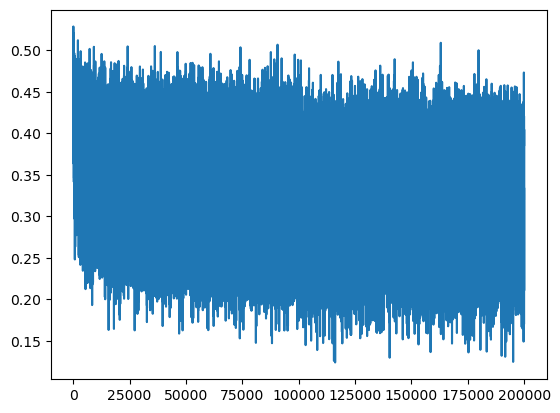

In [17]:
plt.plot(lossi)

In [19]:
# Once we've trained a neural net we'd like to deploy it in some kind of a setting and we'd like to be able
# to feed in a single individual example and get a prediction out from our NN but how do we do that when
# our NN now in forward pass estimates the statistics of the mean and standard deviation of a batch.

# The NN expects batches as an input

# What we will do to workaround this is to add an step after training that calculates and sets the 
# batch mean and standard deviation a single time over the training set

In [19]:
# The benefit is that now we can now also forward a single example
# because the mean and standard deviation are now fixed

# Calibrate the batch norm at the end of training
with torch.no_grad():
    # Pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # Measure the mean/std over the entire training set
    batch_norm_mean = hpreact.mean(0, keepdim=True)
    batch_norm_std = hpreact.std(0, keepdim=True)

In [21]:
batch_norm_mean

tensor([[-2.3148,  0.6874, -0.9136,  0.9966,  1.0880,  1.0840,  1.7472, -2.1107,
          0.5818,  1.4375, -1.6466, -2.7301, -0.4766, -0.1641, -0.0858, -1.1704,
          0.6866, -2.6103, -0.0924,  1.6207, -0.7664, -0.3183,  0.0414,  0.6149,
          1.1046,  0.2279,  2.0388,  0.5843,  0.8445,  1.7754, -0.3646, -0.8379,
         -0.0896, -0.5023, -0.3711, -1.0608, -0.0749,  0.3473, -0.5914,  0.9716,
         -0.4422, -1.3040, -0.3001, -0.2147,  0.6885,  0.6893,  2.0853, -0.7506,
          2.3778,  1.8862,  0.8296,  0.2895,  1.8993,  0.4668,  0.6838, -1.8916,
         -0.0522,  0.4209,  1.3688, -0.9079, -0.4528,  1.1846,  0.5669,  0.6121,
          1.5833,  1.2313, -1.0180,  2.1523, -0.6460,  0.0949, -0.2969, -0.4722,
          0.9620, -1.0408, -2.9998,  0.6501,  1.4310, -0.1545,  0.0938,  0.5273,
          0.2381,  1.2512,  2.0559,  0.6612,  0.0664, -0.0787, -1.6763,  0.2953,
          2.2552, -0.0272, -0.6879,  1.4155, -0.8440, -1.2223, -1.0225,  0.2298,
          0.2184, -0.3140,  

In [22]:
batch_n_mean_running

tensor([[-2.3332,  0.6971, -0.9004,  0.9962,  1.0909,  1.0764,  1.7424, -2.1255,
          0.5695,  1.4166, -1.6568, -2.7355, -0.4875, -0.1739, -0.0800, -1.1531,
          0.6906, -2.6284, -0.1142,  1.6121, -0.7690, -0.2985,  0.0401,  0.6153,
          1.1045,  0.2285,  2.0431,  0.5789,  0.8433,  1.7803, -0.3762, -0.8409,
         -0.0874, -0.5043, -0.3722, -1.0608, -0.0744,  0.3356, -0.5875,  0.9776,
         -0.4503, -1.3271, -0.3025, -0.2114,  0.6912,  0.6979,  2.0831, -0.7656,
          2.3717,  1.8742,  0.8154,  0.2827,  1.8897,  0.4663,  0.6755, -1.8937,
         -0.0541,  0.4227,  1.3852, -0.9075, -0.4680,  1.1779,  0.5595,  0.6070,
          1.5828,  1.2156, -1.0240,  2.1449, -0.6397,  0.1081, -0.3031, -0.4697,
          0.9494, -1.0091, -2.9933,  0.6379,  1.4387, -0.1529,  0.0952,  0.5178,
          0.2360,  1.2392,  2.0274,  0.6699,  0.0741, -0.0824, -1.6807,  0.2983,
          2.2503, -0.0162, -0.6882,  1.4258, -0.8460, -1.2292, -1.0316,  0.2269,
          0.1999, -0.3175,  

### Evaluation

In [23]:
# We don't want to keep the computation graph in order to compute gradients
# which are only needed during the training phase
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size, n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = batch_gain * (hpreact - batch_n_mean_running) / batch_n_stdi_running + batch_bias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.10505747795105


### Sample from the model

In [11]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # Initialize with all ... [0, 0, 0]
    while True:
        # Forward pass the NN
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample the special '.' token, break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

mora.
mayah.
see.
mad.
rylla.
emmadiendraeg.
adelyn.
elin.
shi.
jen.
edeiseananaraelyzion.
kamin.
shuberlyni.
jest.
jair.
jeniqueterian.
brence.
ryyah.
fael.
yuva.


### Parameters initialization

In [12]:
# The probability expected at the beginning should be 1/27 if all the characters have the
# same probability to be chosen

In [13]:
# Negative Log likelihood
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [14]:
# The loss at the begining is bigger than the expected.
# Actual:  27.8817
# Expected: 3.2958

# Note:
#     In training a neural network it is almost the case that we
#     will have a rough idea for what loss to expect at initialization

In [15]:
# The activation of the hidden states
# Most of the values by far take on the value of negative one and one

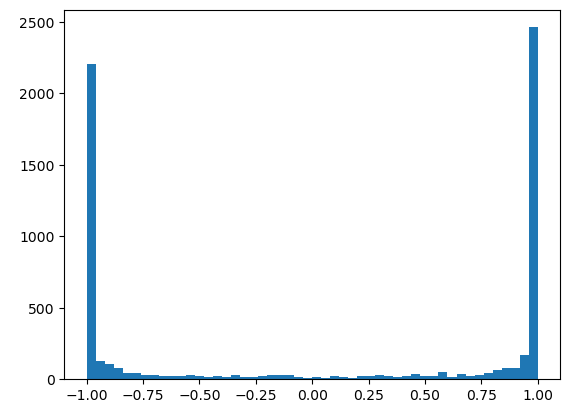

In [16]:
# Pre-activations feed into the tanh are very broad, these takes numbers between [-20, 20]
# and that's why in the tanh() everything is being sqashed and capped to be in the range of 
# negative one and one

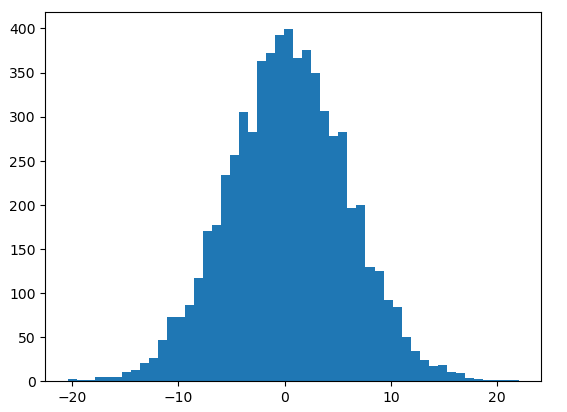

In [17]:
# Let's see how often `h` is in the flat region which causes that backpropagation
# pass directly through the neuron without effect in its gradient because 
# if t is 1 or -1 the sqare of it is 1 and (1 - 1) is zero then the gradient is set to 0
# i.e., self.grad += (1 - t**2) * out.grad

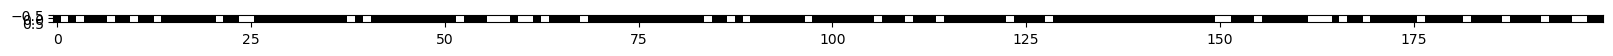

In [18]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

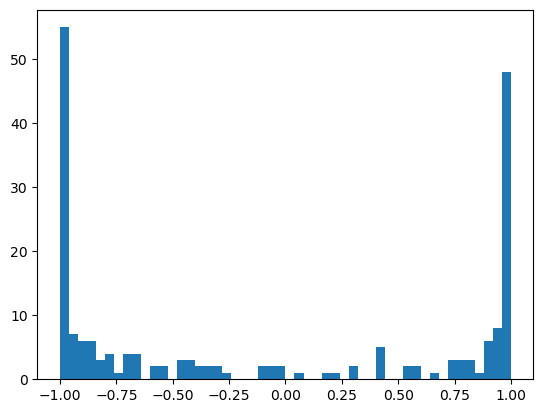

In [12]:
plt.hist(h.view(-1).tolist(), 50);

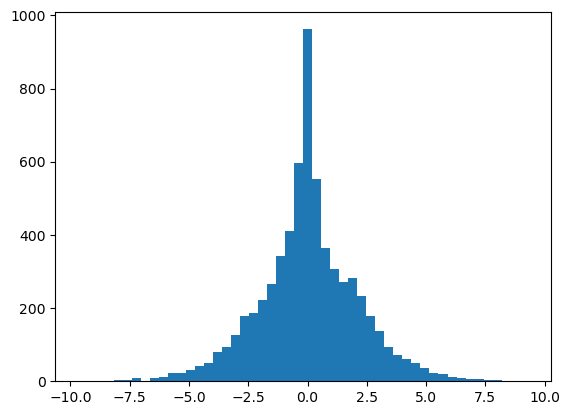

In [20]:
plt.hist(hpreact.view(-1).tolist(), 50);

tensor(0.0203) tensor(1.0114)
tensor(-0.0012) tensor(1.0248)


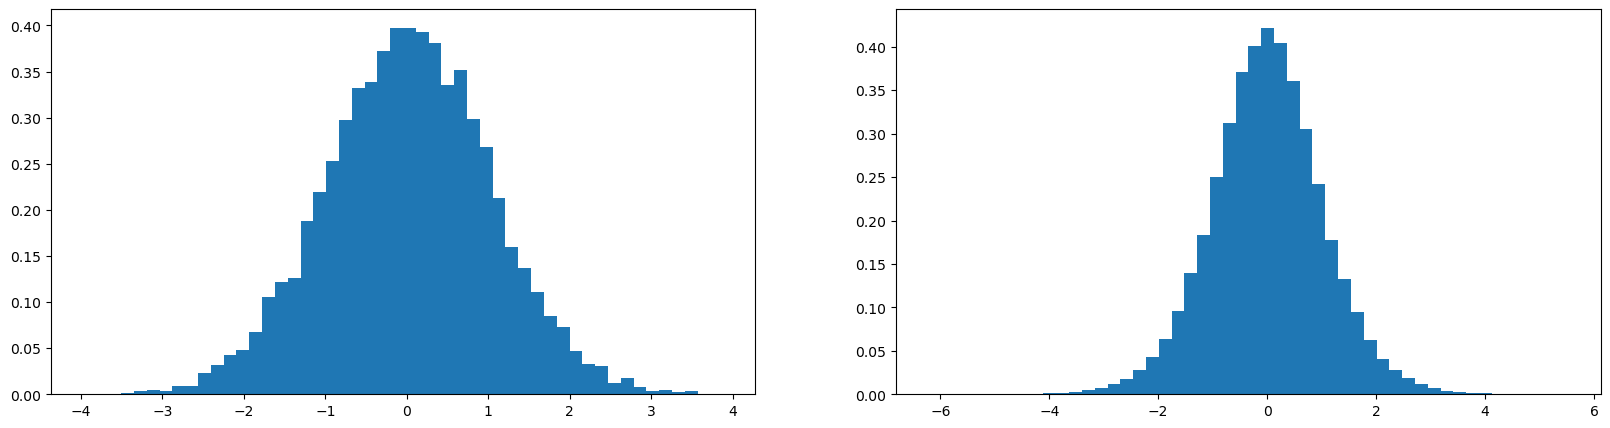

In [13]:
# Mean and variance
X = torch.randn(1000, 10) # Random inputs from a Gausian distribution
# Weights from a Gausian distribution
# These neurons in the hidden layer look at 10 inputs and 200 neurons
W = torch.randn(10, 200) / 10**0.5
y = X @ W # Pre-activations of these neurons


print(X.mean(), X.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [9]:
# At the beginning X is distributed according to the normal distribution with mean
# 0 and standard deviation of 1 (Measure of spread of discussion)

# y isn't distributed according to a normal distribution, with mean 0
# and standard deviation higher than 1 (3.13)

# How can we preserve the standard deviation to be one?
# torch.randn(10, 200) / 10**0.5

### Summary

In [ ]:
# Understanding  the activations, the gradients and theirs statistics in NN
# This becomes increasingly important especially as we make our NN bigger, larger and depper